# **任务描述：**


如何根据据图像的视觉内容为图像赋予一个语义类别（例如，教室、街道等）是图像场景分类的目标，也是图像检索、图像内容分析和目标识别等问题的基础。但由于图片的尺度、角度、光照等多样性以及场景定义的复杂性，场景分类一直是计算机视觉中的一个挑战性问题。

<br/>

**本实践旨在通过一个场景分类的案列，让大家理解和掌握如何使用飞桨动态图搭建一个经典的卷积神经网络。**

<br/>

**特别提示：本实践所用数据集均来自互联网，请勿用于商务用途。**

In [1]:
import os
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from paddle.io import Dataset
device = paddle.set_device('gpu')
device


Place(gpu:0)

In [2]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 224, 224],                              #输入图片的shape
    "class_dim": -1,                                          #分类数
    "src_path":"data/Chinese Medicine.zip",    #原始数据集路径
    "target_path":"data/",                     #要解压的路径
    "train_list_path": "data/train.txt",       #train.txt路径
    "eval_list_path": "data/eval.txt",         #eval.txt路径
    "readme_path": "data/readme.json",         #readme.json路径
    "label_dict":{},                                          #标签字典
    "num_epochs": 10,                                         #训练轮数
    "train_batch_size": 8,                                    #训练时每个批次的大小
    "skip_steps": 10,
    "save_steps": 30, 
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.0001                                          #超参数学习率
    },
    "checkpoints": "work/checkpoints"          #保存的路径

}

# **一、数据准备**

（1）解压原始数据集

（2）按照比例划分训练集与验证集

（3）乱序，生成数据列表

（4）定义数据读取器

In [3]:
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(target_path + "Chinese Medicine")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

In [4]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path+"Chinese Medicine/"
    class_dirs = os.listdir(data_list_path)  
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label=0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别，['river', 'lawn','church','ice','desert']
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = data_list_path  + class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                name_path = path + '/' + img_path                       # 每张图片的路径
                if class_sum % 8 == 0:                                  # 每8张图片取一个做验证数据
                    eval_sum += 1                                       # test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
             
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1 
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
  
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [5]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']

'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

生成数据列表完成！


In [6]:
class dataset(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = img.resize((224, 224), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [7]:

#训练数据加载
train_dataset = dataset('data',mode='train')
train_loader = paddle.io.DataLoader(train_dataset, batch_size=16, shuffle=True)
#测试数据加载
eval_dataset = dataset('data',mode='eval')
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

In [8]:
train_dataset.print_sample(200)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())
print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)

文件名 data/Chinese Medicine/dangshen/dangshen_216.jpg 	标签值 1
787
文件名 data/Chinese Medicine/baihe/b (73).jpg 	标签值 0
115
(3, 224, 224)
(1,)


C:\Users\12631\AppData\Local\Temp\ipykernel_5624\526974579.py:41: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((224, 224), Image.BILINEAR)


# **二、模型配置**

![](https://ai-studio-static-online.cdn.bcebos.com/9ca0744272b0449186f766afcabadd598e24679088a4438dafede05a71b7c141)

VGG的核心是五组卷积操作，每两组之间做Max-Pooling空间降维。同一组内采用多次连续的3X3卷积，卷积核的数目由较浅组的64增多到最深组的512，同一组内的卷积核数目是一样的。卷积之后接两层全连 接层，之后是分类层。由于每组内卷积层的不同，有11、13、16、19层这几种模型，上图展示一个16层的网络结构。



In [9]:
class ConvPool(paddle.nn.Layer):
    '''卷积+池化'''
    def __init__(self,
                 num_channels,
                 num_filters, 
                 filter_size,
                 pool_size,
                 pool_stride,
                 groups,
                 conv_stride=1, 
                 conv_padding=1,
                 ):
        super(ConvPool, self).__init__()  


        for i in range(groups):
            self.add_sublayer(   #添加子层实例
                'bb_%d' % i,
                paddle.nn.Conv2D(         # layer
                in_channels=num_channels, #通道数
                out_channels=num_filters,   #卷积核个数
                kernel_size=filter_size,   #卷积核大小
                stride=conv_stride,        #步长
                padding = conv_padding,    #padding
                )
            )
            self.add_sublayer(
                'relu%d' % i,
                paddle.nn.ReLU()
            )
            num_channels = num_filters
            

        self.add_sublayer(
            'Maxpool',
            paddle.nn.MaxPool2D(
            kernel_size=pool_size,           #池化核大小
            stride=pool_stride               #池化步长
            )
        )

    def forward(self, inputs):
        x = inputs
        for prefix, sub_layer in self.named_children():
            # print(prefix,sub_layer)
            x = sub_layer(x)
        return x
        

In [10]:
class VGGNet(paddle.nn.Layer):
  
    def __init__(self):
        super(VGGNet, self).__init__()       
        self.convpool01 = ConvPool(
            3, 64, 3, 2, 2, 2)  #3:通道数，64：卷积核个数，3:卷积核大小，2:池化核大小，2:池化步长，2:连续卷积个数
        self.convpool02 = ConvPool(
            64, 128, 3, 2, 2, 2)
        self.convpool03 = ConvPool(
            128, 256, 3, 2, 2, 3) 
        self.convpool04 = ConvPool(
            256, 512, 3, 2, 2, 3)
        self.convpool05 = ConvPool(
            512, 512, 3, 2, 2, 3)       
        self.pool_5_shape = 512 * 7* 7
        self.fc01 = paddle.nn.Linear(self.pool_5_shape, 4096)
        self.fc02 = paddle.nn.Linear(4096, 4096)
        self.fc03 = paddle.nn.Linear(4096, train_parameters['class_dim'])

    def forward(self, inputs, label=None):
        # print('input_shape:', inputs.shape) #[8, 3, 224, 224]
        """前向计算"""
        out = self.convpool01(inputs) 
        out = self.convpool02(out) 
        out = self.convpool03(out) 
        out = self.convpool04(out) 
        out = self.convpool05(out)      

        out = paddle.reshape(out, shape=[-1, 512*7*7])
        out = self.fc01(out)
        out = self.fc02(out)
        out = self.fc03(out)
        
        if label is not None:
            acc = paddle.metric.accuracy(input=out, label=label)
            return out, acc
        else:
            return out
            

# 三、模型训练 

In [11]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

In [12]:
print(train_parameters['class_dim'])
print(train_parameters['label_dict'])

5
{'0': 'baihe', '1': 'dangshen', '2': 'gouqi', '3': 'huaihua', '4': 'jinyinhua'}


C:\Users\12631\AppData\Local\Temp\ipykernel_5624\526974579.py:41: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((224, 224), Image.BILINEAR)


epo: 0, step: 10, loss is: [1.6063197], acc is: [0.25]
epo: 0, step: 20, loss is: [1.7404811], acc is: [0.125]
epo: 0, step: 30, loss is: [1.3692734], acc is: [0.25]
save model to: work/checkpoints/save_dir_30.pdparams
epo: 0, step: 40, loss is: [1.1832886], acc is: [0.4375]
epo: 0, step: 50, loss is: [0.43100542], acc is: [1.]
epo: 1, step: 60, loss is: [1.0386862], acc is: [0.4375]
save model to: work/checkpoints/save_dir_60.pdparams
epo: 1, step: 70, loss is: [1.0455766], acc is: [0.5625]
epo: 1, step: 80, loss is: [1.0679083], acc is: [0.625]
epo: 1, step: 90, loss is: [1.0763837], acc is: [0.3125]
save model to: work/checkpoints/save_dir_90.pdparams
epo: 1, step: 100, loss is: [0.93910813], acc is: [0.6666667]
epo: 2, step: 110, loss is: [1.5991504], acc is: [0.1875]
epo: 2, step: 120, loss is: [1.2477893], acc is: [0.375]
save model to: work/checkpoints/save_dir_120.pdparams
epo: 2, step: 130, loss is: [0.9788834], acc is: [0.5]
epo: 2, step: 140, loss is: [1.2123208], acc is: [0

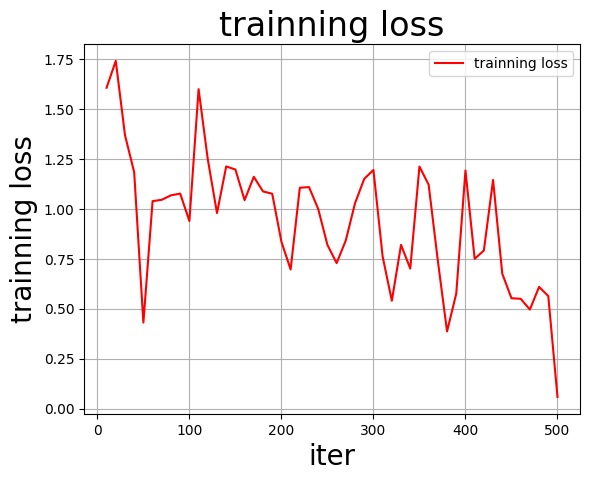

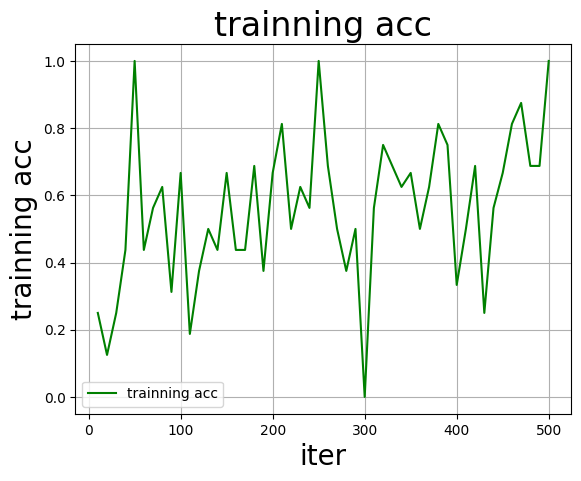

In [13]:
model = VGGNet()
model.train()
cross_entropy = paddle.nn.CrossEntropyLoss()
optimizer = paddle.optimizer.Adam(learning_rate=train_parameters['learning_strategy']['lr'],
                                  parameters=model.parameters()) 

steps = 0
Iters, total_loss, total_acc = [], [], []

for epo in range(train_parameters['num_epochs']):
    for _, data in enumerate(train_loader()):
        steps += 1
        x_data = data[0]
        y_data = data[1]
        predicts, acc = model(x_data, y_data)
        loss = cross_entropy(predicts, y_data)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if steps % train_parameters["skip_steps"] == 0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            #打印中间过程
            print('epo: {}, step: {}, loss is: {}, acc is: {}'\
                  .format(epo, steps, loss.numpy(), acc.numpy()))
        #保存模型参数
        if steps % train_parameters["save_steps"] == 0:
            save_path = train_parameters["checkpoints"]+"/"+"save_dir_" + str(steps) + '.pdparams'
            print('save model to: ' + save_path)
            paddle.save(model.state_dict(),save_path)
paddle.save(model.state_dict(),train_parameters["checkpoints"]+"/"+"save_dir_final.pdparams")
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

# 四、模型评估

In [14]:

'''
模型评估
'''
model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_eval = VGGNet()
model_eval.set_state_dict(model__state_dict) 
model_eval.eval()
accs = []

for _, data in enumerate(eval_loader()):
    x_data = data[0]
    y_data = data[1]
    predicts = model_eval(x_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    accs.append(acc.numpy()[0])
print('模型在验证集上的准确率为：',np.mean(accs))

C:\Users\12631\AppData\Local\Temp\ipykernel_5624\526974579.py:41: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((224, 224), Image.BILINEAR)


模型在验证集上的准确率为： 0.71944445


# **五、模型预测**

In [15]:
def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path + "Chinese Medicine Infer")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1)) / 255 # HWC to CHW 及归一化
    return img


infer_src_path = 'data/Chinese Medicine Infer.zip'
infer_dst_path = 'data/'
unzip_infer_data(infer_src_path,infer_dst_path)

label_dic = train_parameters['label_dict']

In [16]:

model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_predict = VGGNet()
model_predict.set_state_dict(model__state_dict) 
model_predict.eval()
infer_imgs_path = os.listdir(infer_dst_path+"Chinese Medicine Infer")
print(infer_imgs_path)
for infer_img_path in infer_imgs_path:
    infer_img = load_image(infer_dst_path+"Chinese Medicine Infer/"+infer_img_path)
    infer_img = infer_img[np.newaxis,:, : ,:]  #reshape(-1,3,224,224)
    infer_img = paddle.to_tensor(infer_img)
    result = model_predict(infer_img)
    lab = np.argmax(result.numpy())
    print("样本: {},被预测为:{}".format(infer_img_path,label_dic[str(lab)]))

['baihe01.jpg', 'baihe02.jpg', 'dangshen01.jpg', 'dangshen02.jpg', 'gouqi01.jpg', 'gouqi02.jpg', 'huaihua01.jpg', 'huaihua02.jpg', 'jinyinhua01.jpg', 'jinyinhua02.jpg']
样本: baihe01.jpg,被预测为:baihe
样本: baihe02.jpg,被预测为:baihe


C:\Users\12631\AppData\Local\Temp\ipykernel_5624\3837268103.py:18: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((224, 224), Image.BILINEAR)


样本: dangshen01.jpg,被预测为:baihe
样本: dangshen02.jpg,被预测为:dangshen
样本: gouqi01.jpg,被预测为:gouqi
样本: gouqi02.jpg,被预测为:gouqi
样本: huaihua01.jpg,被预测为:huaihua
样本: huaihua02.jpg,被预测为:jinyinhua
样本: jinyinhua01.jpg,被预测为:jinyinhua
样本: jinyinhua02.jpg,被预测为:jinyinhua
